# Oxygen Budget Analysis 

This notebook analyzes the O$_2$ budget from POP output. Dissolved oxygen in the ocean's interior is simulated following:

$$
\frac{\partial{O_2}}{\partial{t}}= \underbrace{- \frac{\partial{U.O_2}}{\partial{x}} -\frac{\partial{V.O_2}}{\partial{y}}}_\text{Lateral Advection}
- \overbrace{\frac{\partial{W.O_2}}{\partial{z}}}^\text{Vertical Advection}
+ \underbrace{A_h.\nabla^2{O_2}}_\text{Lateral Mixing}
+\overbrace{\frac{\partial{}}{\partial{z}}k.\frac{\partial{O_2}}{\partial{z}}}^\text{Vertical Mixing}
+ \underbrace{ J(O_2)  }_\text{Sources - Sinks}
$$



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.simplefilter("ignore") # Silence warnings

import xarray as xr
import numpy as np
from tqdm import tqdm
import xgcm 
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import cartopy
import cartopy.crs as ccrs
import proplot 
import matplotlib.patches as patches

from utils import *

In [18]:
C=CLSTR(1,15,200,10)

In [19]:
C

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeddebba/proxy/37364/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeddebba/proxy/37364/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:45598,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeddebba/proxy/37364/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
dsh=xr.open_mfdataset({'/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/O2_Budget_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/O2_Budget_Eddy_Mean.nc',})

du=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/CLM/[UVW]VEL.CLM.nc')
dshm=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/[UVW]_dO2m_Mean.nc')
dshd=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/[UVW]_dO2_Mean.nc')
dshe=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/DIVde_Mean.nc')

# dshm=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/DIVd_Mean.nc')
# dshd=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/DIVdm_Mean.nc')
# dshe=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/DIVde_Mean.nc')


### Plot 

In [5]:
def plot_depth_section(ax,x,z, var,cntf,lev,clr,units,title,coords,fs,fsx,lw,alp,cb_on,profile):
    if cntf==True: 
        cs= ax.contourf(x,z,var,levels=lev,cmap=clr,extend='both')
        if cb_on==True:
            cb = plt.colorbar(cs, ax=ax, orientation='vertical', extend='both',pad=0.02)#, aspect=20)  
#             cb.ax.set_title(units,fontsize=fs-1,pad=0.2)
            cb.set_label(units, rotation=0,size=fs-2,position=(0,1.08))
            cb.ax.tick_params(labelsize=fs-1)
            cb.ax.minorticks_off()
    if cntf==False: cs= ax.contour(x,z,var,colors=clr,linewidths=lw,levels=lev,alpha=alp)
    ax.set_title(title,loc='center',fontsize=fs)
    ax.set_ylim(coords[0]); ax.set_xlim(coords[1]); ax.minorticks_on(); 
    ax.set_ylabel('Depth (m)',fontsize=fs-2); 
    ax.set_aspect('auto')
    if profile=='lon': ax.set_xlabel('Latitude ($^{o}$N)',fontsize=fs-2)
    if profile=='lat': ax.set_xlabel('Longitude ($^{o}$E)',fontsize=fs-2)
    ax.set_title(title,pad=0.01,fontsize=fs, loc='center');
    ax.tick_params(axis='both', labelsize=fs)  
    return ax 

def plot_cmap(ax,lon,lat, var,vmn, vmx, stp, clr,units,title,coor,fs,fsx,lon_lab,lat_lab):
    ax.set_extent(coor,crs=cartopy.crs.PlateCarree())
    pc= ax.contourf(lon,lat,var,np.arange(vmn,vmx,stp),cmap=clr,transform=ccrs.PlateCarree(), extend='both') #, 
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.1, edgecolor='black', facecolor='grey'))
    cb = plt.colorbar(pc, ax=ax, orientation='vertical', extend='both',pad=0.02)#, aspect=20)  
    cb.set_label(units, rotation=0,size=fs-3,position=(0.0,1.08))
#     cb.ax.set_title(units,fontsize=fs-1,pad=0.2)
    cb.ax.minorticks_off()
    cb.ax.tick_params(labelsize=fs)
    ax.set_aspect('auto')
    ax.set_title(title,loc='center',fontsize=fs)
    gl=ax.gridlines(draw_labels=True)
    gl.xlabel_style = {'size': fsx, 'color': 'black'}; gl.ylabel_style = {'size': fsx, 'color': 'black'}; 
    gl.xlabels_top = False; gl.ylabels_right= False; gl.xlines = False; gl.ylines = False
    gl.xlocator = mticker.FixedLocator(lon_lab); gl.ylocator = mticker.FixedLocator(lat_lab)
    gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
    return ax


### Integrate over depth, meridional, zonal bands

In [6]:
top=50; bot=150
Si=2  ; Ni=6 
Ei=-100 ; Wi=-160


clr_o2='NegPos'
om_clr='blue'
omz_clr='green'
odz_clr='lime'


N,W=find_indices(dsh.TLONG,dsh.TLAT,360+Wi,Ni)
S,E=find_indices(dsh.TLONG,dsh.TLAT,360+Ei,Si)

100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


<bound method Figure.tight_layout of <Figure size 2500x700 with 12 Axes>>

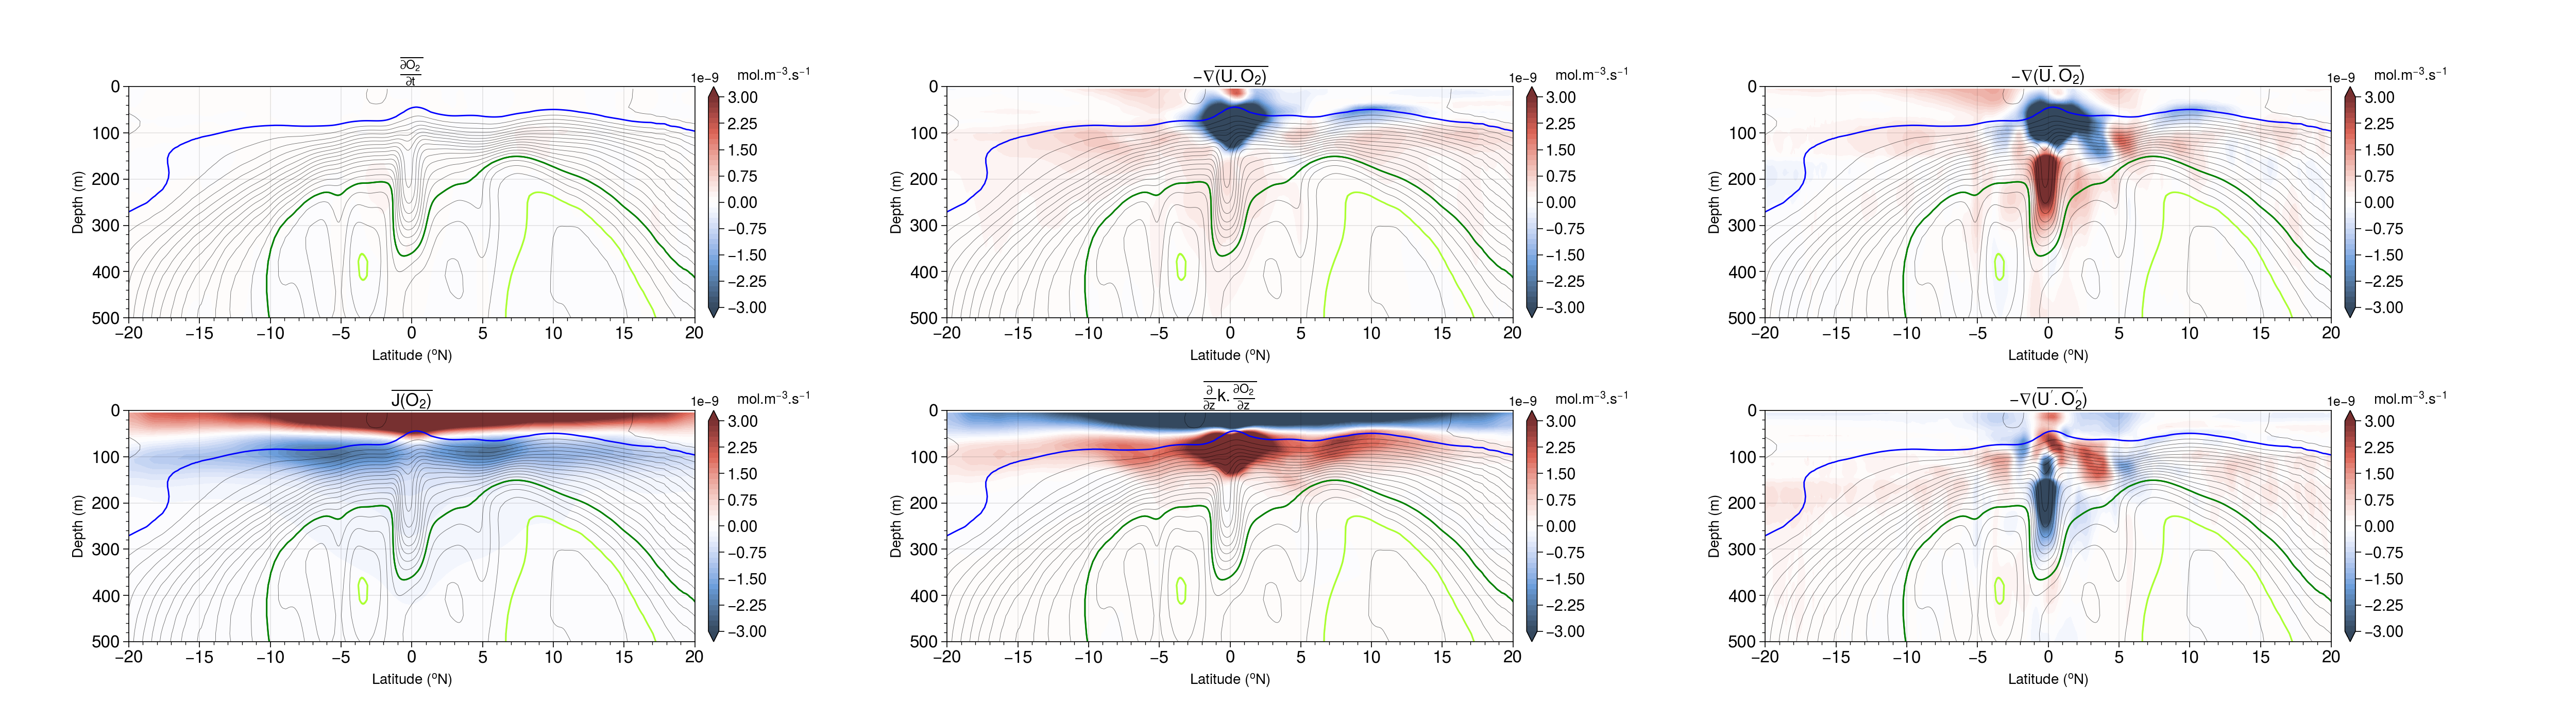

In [ ]:
fig = plt.figure(figsize=(25,7),dpi=100,)
gs = fig.add_gridspec(nrows=2, ncols=3, left=0.05, right=0.95, wspace=0.2, hspace=0.4)

fs=12; fsx=5; 
SS=-20; NN=20
tops=0. ; bots=500.; 
coords=[[bots,tops],[SS,NN]]

om_clr='blue'

var= [dsh.TEND_O2.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.DIV.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.DIVm.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.DIVp.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.VDIF.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.J_O2.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),]

cntf= True ; cnt= False 
units=['mol.m$^{-3}$.s$^{-1}$']
title=[r'$\overline{\frac{\partial{O_2}}{\partial{t}}}$ ', 
     r'$-\nabla{\overline{(U.O_2)}}$ ',
     r'$-\nabla{(\overline{U}.\overline{O_2})}$ ',
     r"$-\nabla{(\overline{U'.O_2'})}$",
     r'$\overline{\frac{\partial{}}{\partial{z}}k.\frac{\partial{O_2}}{\partial{z}}}$ ',
     r'$\overline{J(O_2)}$ ']

clr=[clr_o2]
lw=0.5; alp=1;cb_on=True

lo = -3e-9; hi = -lo; hi2 = -lo; dsc = -lo*0.5e-1
y=dsh.TLAT[:,E]
z= dsh.z_t*1e-2

i=[0,0,0,1,1,1]; j=[0,1,2,2,1,0]
for k in tqdm(np.arange(0,6)):#len(VAR))):
    ax = fig.add_subplot(gs[i[k],j[k]])
    cax= plot_depth_section(ax,y,z,var[k],cntf,np.arange(lo, hi+dsc, dsc),
                            clr[0],units[0],title[k],coords,fs,fsx,lw,alp,cb_on,'lon')
    pch= cax.contour(y, z,dsh.O2.isel(nlon=slice(W,E)).mean('nlon'),
                     colors='black', alpha=0.6,linewidths=0.3, levels = np.arange(0,300.1,10))
    pch= cax.contour(y, z,dsh.O2.isel(nlon=slice(W,E)).mean('nlon'),
                     colors=om_clr, alpha=1, linewidths=1, levels = np.arange(200,200.1,0.1))
    pch= cax.contour(y, z,dsh.O2.isel(nlon=slice(W,E)).mean('nlon'),
                     colors=omz_clr, alpha=1, linewidths=1, levels = np.arange(60,60.1,0.1))
    pch= cax.contour(y, z,dsh.O2.isel(nlon=slice(W,E)).mean('nlon'),
                     colors=odz_clr, alpha=1, linewidths=1, levels = np.arange(20,20.1,0.1))
    
    
#     cs2= cax.contour(y, z,(dsp.PD.isel(nlon=slice(W,E)).mean('nlon').squeeze()-1)*1e3, colors='orange', linewidths=1.0, levels=np.arange(20,27,0.5))
#     ax2.clabel(cs2,np.arange(20,27,0.5), fontsize=10)


fig.tight_layout

In [ ]:
savefig(fig,"Final_Figures/O2_budget_Meridional_HR")